# <font style="color: rgb(0,0,0);">Option B: </font> <font style="color: rgb(190,138,67);">Transport efficiency</font>

In [17]:
# pip install "C:\Program Files\AGI\STK 12\bin\AgPythonAPI\agi.stk12-12.2.0-py3-none-any.whl"
# run this notebook from STK's Python Scripting Interface

In [18]:
# STK library imports
from agi.stk12.stkdesktop import STKDesktop
from agi.stk12.stkobjects import *
from agi.stk12.stkutil import *
from agi.stk12.vgt import *
# if using astrogator uncomment the below
# from agi.stk12.stkobjects.astrogator
# if using aviator uncomment the below
# from agi.stk12.stkobjects.aviator

# Python helper library imports
import os
from tqdm.notebook import tqdm
from ipywidgets import *
import time
import numpy as np
import plotly.express as px
import xarray as xr

In [3]:
# helper functions

# model for launch segment

# plot xArray data

## Destination: Gateway (Near-Rectilinear Halo Orbit)
> open file "Gateway_PROP_Mass_Point.sc" in STK

### connect to STK session and grab elements

In [21]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('NRHO_Sat')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

agi.stk12.stkobjects.AgStkObjectRoot

In [5]:
#satellite  = AgSatellite(root.CurrentScenario.Children.New(AgESTKObjectType.eSatellite,"LeoSat"))
#place_start  = AgPlace(scenario.Children.New(AgESTKObjectType.ePlace,"Start"))

In [7]:
#def analyse(object):
#    print([method_name for method_name in dir(object)if callable(getattr(object, method_name))])
#print(satellite.Propagator.__dict__.keys())

# use dir() instead

In [8]:
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
# Name
# FinalValue
# LastUpdate
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
# Name
# CurrentValue
# DesiredValue
# Difference
# Values


# pull data
#print(satellite.Propagator.MainSequence.Item(2).GetResultValue('Eccentricity'))

#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue
#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0).Name

# set data
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).BurnoutVelocity._SetFixedVelocity(1)
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = 44
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0

In [10]:
#airtemps = xr.tutorial.open_dataset('air_temperature').air.isel(time=500)
#airtemps

In [15]:
#colorbar_title = results.attrs['var_desc'] + '<br>(%s)'%results.attrs['units']
#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
#fig.show()
#fig.write_image("images/fig1.pdf")
#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print()
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).Name)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000)

#dir(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0))

#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status)

#dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
#dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
#dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
#dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
#dv2 = np.linalg.norm(dv2_vec)
#print(dv2)

### control STK and compute global result

In [16]:
####################################################################################
# WARNING !    this step takes approx. 4 hours to compute for 5 deg resolution     #
####################################################################################

# calculation steps in deg for geodetic location
resolution = 30

print('Result image resolution:',1+(360/resolution),'x',1+(180/resolution))
n_total = (1+(360/resolution))*(1+(180/resolution))
print('number of calculations:',n_total)

if n_total != int(n_total): print("WARNING: non matching map!")

Longitude = []
Latitude = []

for Lon in range(-180,181,resolution):
    Longitude.append(Lon)
for Lat in range(-90,91,resolution):
    Latitude.append(Lat)


Latitude = list(reversed(Latitude))

deltaV_Gateway = np.zeros((len(Latitude), len(Longitude)))
deltaV_Gateway[:] = np.nan

fuel_mass_Gateway = np.zeros((len(Latitude), len(Longitude)))
fuel_mass_Gateway[:] = np.nan

print()
print(len(Longitude),Longitude)
print()
print(len(Latitude),Latitude)

with tqdm(total=n_total) as pbar:
    for Lat_count, Lat in enumerate(Latitude):
        for Lon_count, Lon in enumerate(Longitude):
            #print("Lat:",Lat,"Lon:",Lon)
            place_start.Position.AssignGeodetic(Lat,Lon,0)
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = Lat
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Longitude = Lon
            if Lon > -90 and Lon < 90:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = -180
            else:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0
                
            satellite.Propagator.RunMCS()
            check1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status
            check2 = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).Status
            if check1 == "Converged" and check2 == "Converged":
                
                # Launch: Burnout.FixedVelocity
                dv1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                # Maneuver: ImpulsiveMnvr.Pointing.Cartesian.X /Y /Z
                dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
                dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
                dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
                dv2 = np.linalg.norm(dv2_vec)

                deltaV_Gateway[Lat_count][Lon_count] = dv2
                fuel_mass_Gateway[Lat_count][Lon_count] = 0
                
            else:
                print("ERROR","did NOT Converge for","Lat:",Lat,"Lon:",Lon)
                
            pbar.update(1)

Result image resolution: 73.0 x 37.0
number of calculations: 2701.0

73 [-180, -175, -170, -165, -160, -155, -150, -145, -140, -135, -130, -125, -120, -115, -110, -105, -100, -95, -90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180]

37 [90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50, -55, -60, -65, -70, -75, -80, -85, -90]


  0%|          | 0/2701.0 [00:00<?, ?it/s]

STKRuntimeError: Position central bodies were not equivalent.

### save result in xArray

In [7]:
xA_fuel_mass_Gateway = xr.DataArray(
    data=fuel_mass_Gateway,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Longitude),
        lat=(["lat"], Latitude)
    ),
    attrs=dict(
        description="DeltaV to Gateway",
        var_desc="deltaV",
        units="m/s",
    ),
)

xA_fuel_mass_Gateway.to_netcdf("maps/fuel_mass_Gateway.nc")

In [ ]:
# load array
xA_fuel_mass_Gateway = xr.open_dataarray("maps/fuel_mass_Gateway.nc")

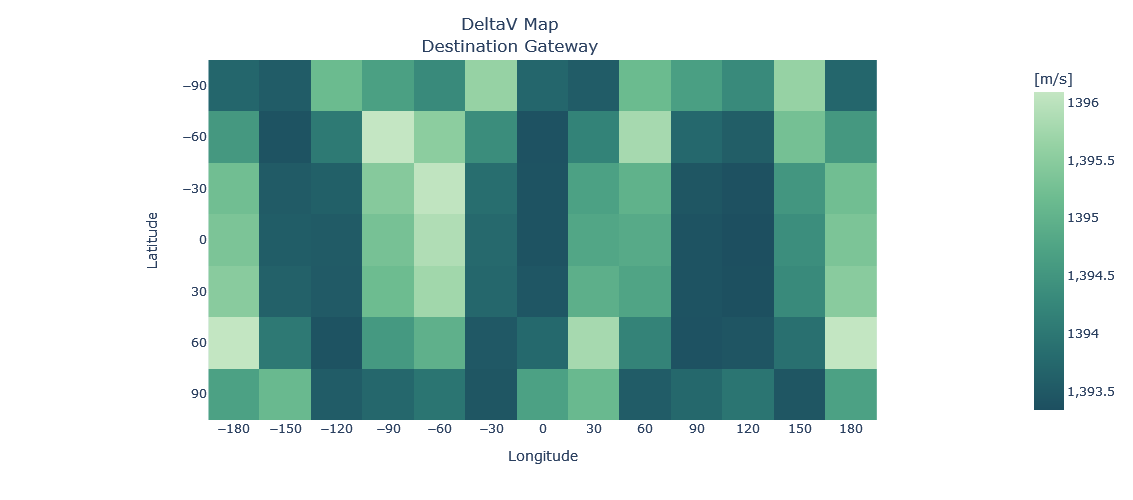

In [14]:
colorbar_title = xA_fuel_mass_Gateway.attrs['var_desc'] + '<br>(%s)'%xA_fuel_mass_Gateway.attrs['units']

#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
fig = px.imshow(img=xA_fuel_mass_Gateway,
                width=1000,
                height=500,
                color_continuous_scale='blugrn_r',
                aspect='equal')

fig.update_xaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
fig.update_yaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-90,-60,-30,0,30,60,90])


fig.update_layout(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    title= 'DeltaV Map<br>Destination Gateway',
    title_x=0.45
)


#fig.write_image("fig/dv1.pdf")
fig.write_image("doc/img/dv_Gateway.pdf")
fig.show()


In [ ]:
#print(scenario.StartTime)
#print(scenario.StopTime)

In [ ]:
root.ExecuteCommand('SetState */Satellite/LeoSat Classical TwoBody "' +
                    str(scenario.StartTime) + '" "' + str(scenario.StopTime) +
                    '" 60 ICRF  "' + str(scenario.StartTime) + '" 7200000.0 0.0 90 0.0 0.0 0.0')

In [ ]:
access = satellite.GetAccessToObject(target)
access.ComputeAccess()

In [ ]:
accessDP         = access.DataProviders.Item('Access Data')

results          = accessDP.Exec(scenario.StartTime, scenario.StopTime)

accessStartTimes = results.DataSets.GetDataSetByName('Start Time').GetValues()

accessStopTimes  = results.DataSets.GetDataSetByName('Stop Time').GetValues()

print(accessStartTimes,accessStopTimes)

In [ ]:
accessIntervals = access.ComputedAccessIntervalTimes

dataProviderElements = ['Start Time', 'Stop Time']

for i in range(0,accessIntervals.Count):
    times = accessIntervals.GetInterval(i)
    print(times)

### Retrieve the Satellite Altitude Data From STK

Retrieve and view the altitude of the satellite during an access interval. In the following lines, note how the data providers must follow the data provider folder, sub-folder, and selection.

In [ ]:
satelliteDP       = satellite.DataProviders.Item('LLA State')

satelliteDP2      = satelliteDP.Group.Item('Fixed')

rptElements       = ['Time', 'Lat', 'Lon', 'Alt']

satelliteDPTimeVar = satelliteDP2.ExecElements(accessStartTimes,accessStopTimes, 60, rptElements)

satelliteAltitude = satelliteDPTimeVar.DataSets.GetDataSetByName('Alt').GetValues()

print(satelliteAltitude)

## Destination: Low Lunar Orbit (Equatorial)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Eq')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Low Lunar Orbit (Polar)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Pol')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Lagrange Point (L1) - Earth Moon System
> open file "Gateway_PROP_Mass_Point.sc" in STK

## Destination: Low Earth Orbit (Equatorial) - Starship refuel
> open file "Gateway_PROP_Mass_Point.sc" in STK